# House Pricing


In [34]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline


In [5]:
data_path = Path().resolve().parent / 'data' / 'housing'
data_file = data_path / 'housing.csv'
print(f'Path: {data_path} exists: {data_path.exists()}')

Path: /home/luiscberrocal/PycharmProjects/ml_hands_on/data/housing exists: True


## Load data

In [6]:
df = pd.read_csv(data_file)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


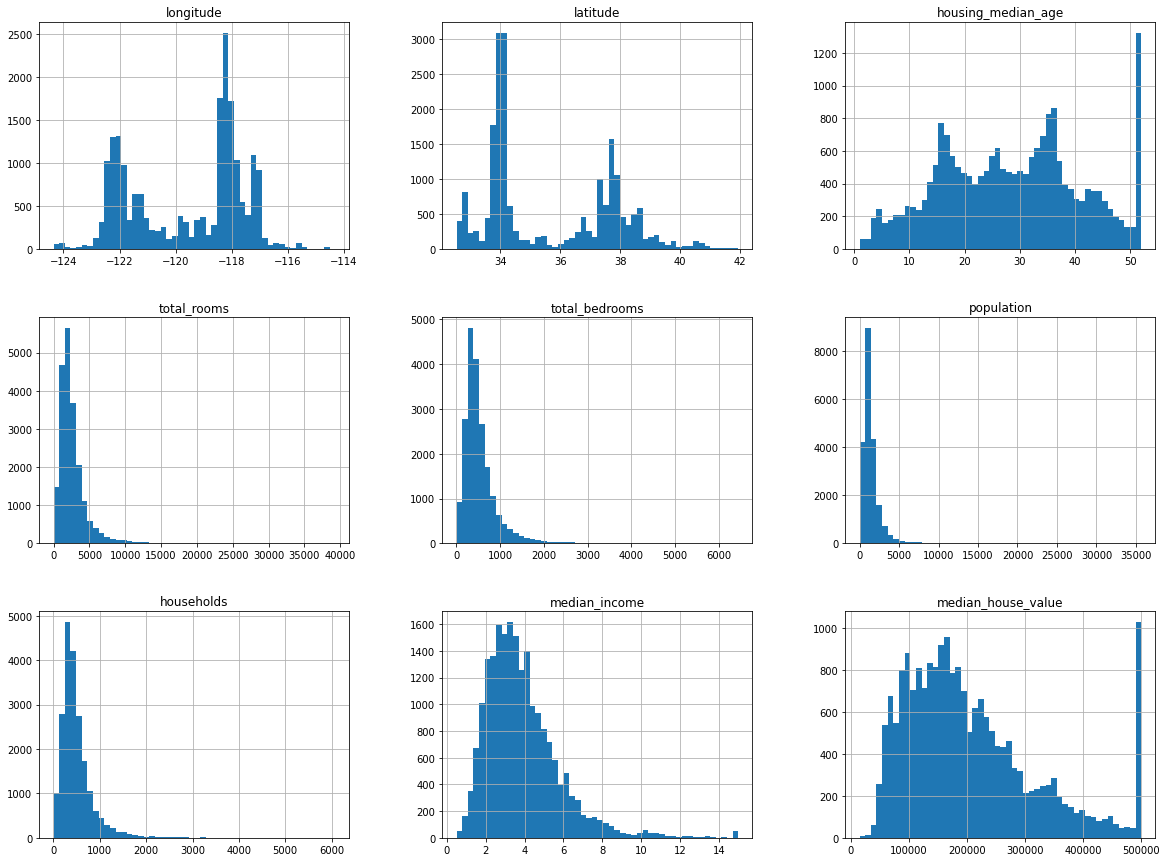

In [9]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

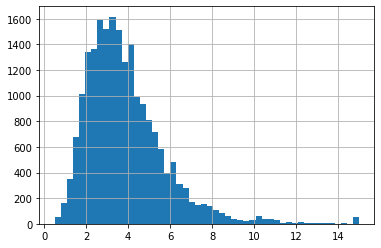

In [10]:
df['median_income'].hist(bins=50)
plt.show()

## Data exploration

### Null values

In [11]:
df.isnull().sum() /df.count() * 100

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.013067
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

### Correlation

In [12]:
corr_matrix =df.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

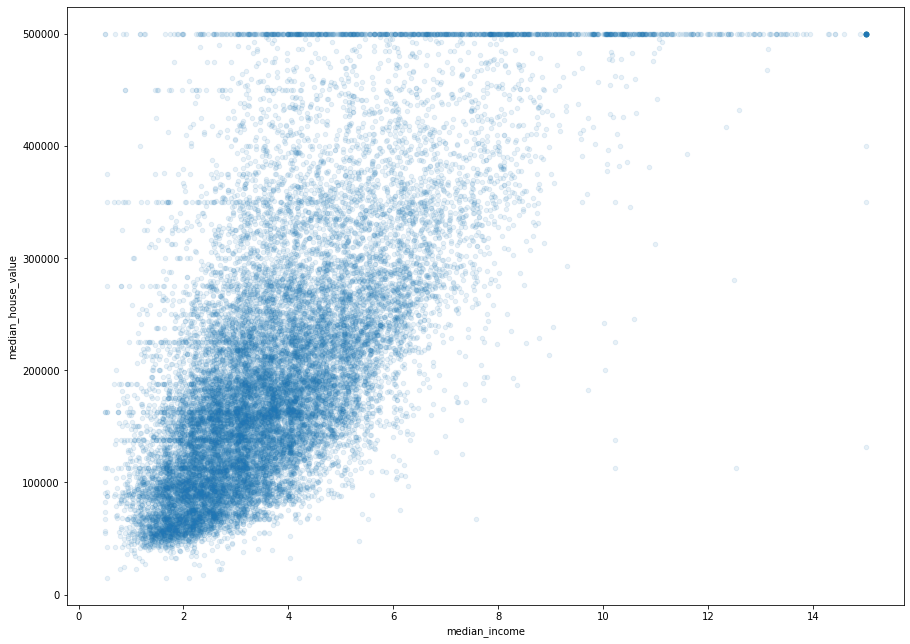

In [13]:
df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(15, 11))
plt.show()

#### Adding extra attributes

In [28]:

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, df):
        col_names = "total_rooms", "total_bedrooms", "population", "households"
        self.rooms_ix, self.bedrooms_ix, self.population_ix, self.households_ix = [
            df.columns.get_loc(c) for c in col_names] #

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_x_household = X[:, self.rooms_ix] / X[:, self.households_ix]
        bedrooms_x_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
        population_x_household = X[:, self.population_ix] / X[:, self.households_ix]
        vals =  np.c_[X, rooms_x_household, population_x_household, bedrooms_x_room]
        #df_extra_attribs = pd.DataFrame(vals,
        #        columns=list(df.columns)+["rooms_x_household", "bedrooms_x_room", "population_x_household"],
        #        index=df.index)
        return vals

In [30]:
attr_adder = CombinedAttributeAdder(df)
housing_extra =attr_adder.transform(df.values)

housing_extra

array([[-122.23, 37.88, 41.0, ..., 6.984126984126984, 2.5555555555555554,
        0.14659090909090908],
       [-122.22, 37.86, 21.0, ..., 6.238137082601054, 2.109841827768014,
        0.15579659106916466],
       [-122.24, 37.85, 52.0, ..., 8.288135593220339, 2.8022598870056497,
        0.12951601908657123],
       ...,
       [-121.22, 39.43, 17.0, ..., 5.20554272517321, 2.325635103926097,
        0.21517302573203195],
       [-121.32, 39.43, 18.0, ..., 5.329512893982808, 2.1232091690544412,
        0.21989247311827956],
       [-121.24, 39.37, 16.0, ..., 5.254716981132075, 2.616981132075472,
        0.22118491921005387]], dtype=object)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#df.drop('ocean_proximity', axis='columns', inplace=True)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributeAdder(df)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(df)

In [21]:
#df['rooms_x_household'] = df['total_rooms']/df['households']
#df['bedrooms_x_room'] = df['total_bedrooms']/df['total_rooms']
#df['population_x_household'] = df['population']/df['households']

In [22]:
corr_matrix =df.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [ ]:
df.plot(kind='scatter', x='bedrooms_x_room', y='median_house_value', alpha=0.1, figsize=(15, 11))
plt.show()

## Split data

In [ ]:
bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf]
labels = [1, 2, 3, 4, 5]
df['income_cat'] = pd.cut(df['median_income'], bins=bins, labels=labels)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(df, df['income_cat']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]


In [ ]:
test_set['income_cat'].value_counts() / len(test_set)